# W207 Group Project - What's Cooking?

Group members: Daniel Volk, Aaron Yuen

Kaggle competition link: https://www.kaggle.com/c/whats-cooking

## Business Understanding

#### Description from Kaggle:

Picture yourself strolling through your local, open-air market... What do you see? What do you smell? What will you make for dinner tonight?

If you're in Northern California, you'll be walking past the inevitable bushels of leafy greens, spiked with dark purple kale and the bright pinks and yellows of chard. Across the world in South Korea, mounds of bright red kimchi greet you, while the smell of the sea draws your attention to squids squirming nearby. India’s market is perhaps the most colorful, awash in the rich hues and aromas of dozens of spices: turmeric, star anise, poppy seeds, and garam masala as far as the eye can see.

Some of our strongest geographic and cultural associations are tied to a region's local foods. This playground competitions asks you to predict the category of a dish's cuisine given a list of its ingredients. 

#### What problem are we trying to solve?

The problem at hand is to categorize the cuisine of a recipe based on the provided list of ingredients. This competition was hosted by Yummly, a company that builds a mobile app and website that provides recipe recommendations personalized to the individual's tastes. This is a multi-class classification problem where the input is a list of strings (ingredients) and the output we are trying to predict is one of the various classes of cuisine. 

#### What are the relevant metrics?

In this classification problem, there are a few relevant metrics we will explore:
1. Accuracy
2. Precision
3. Recall

#### How do we plan to improve these metrics?

We will start by establishing a baseline using a very simple classifier with little parameter tuning and feature engineering.  Once we have established a baseline, we will then build upon it with trying various models, tuning various hyper-parameters, and spend considerable effects in feature engineering. We will also iterate through error analysis, which will also be shared in this deliverable as well.

MORE HERE ON SPECIFIC TECHNIQUES WE WILL TRY

#### What will we deliver?

The main deliverable is this iPython notebook that completes the full end-to-end project from problem scope, data understanding, exploratory analysis, baseline model, feature engineering, error analysis and final results.

## Data Understanding

#### Library Imports

In [140]:
# Loading all relevant libraries
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import re

matplotlib.rc('font', **{'weight' : 'bold', 'size':10} )

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, precision_score, recall_score, f1_score, auc
import string
import seaborn as sn

#### Data Loading

The provided sources of data from the competition are:

1. train.json - Includes both the list of ingredients as features and the cuisine as the class
2. test.json - Includes only the list of ingredients as features. The cuisine (e.g. the class) is not present.


In [2]:
# Read train and test dataset from the provided JSONs
train = pd.read_json("data/train.json")
test = pd.read_json("data/test.json")

# Separate to raw features dataframe
X_train_all = train["ingredients"]
X_test = test["ingredients"]

# Separate label dataframe
y_train_all = train["cuisine"]

In [3]:
print(X_train_all.shape)
print(y_train_all.shape)

(39774,)
(39774,)


#### Example features and labels

In [4]:
print("First 10 example features from the training set")
print(X_train_all.head(10))
print("")

print("First 10 example labels from the training set")
print(y_train_all.head(10))
print("")

print("First 10 example features from the test set")
print(X_test.head(10))
print("")

First 10 example features from the training set
0    [romaine lettuce, black olives, grape tomatoes...
1    [plain flour, ground pepper, salt, tomatoes, g...
2    [eggs, pepper, salt, mayonaise, cooking oil, g...
3                  [water, vegetable oil, wheat, salt]
4    [black pepper, shallots, cornflour, cayenne pe...
5    [plain flour, sugar, butter, eggs, fresh ginge...
6    [olive oil, salt, medium shrimp, pepper, garli...
7    [sugar, pistachio nuts, white almond bark, flo...
8    [olive oil, purple onion, fresh pineapple, por...
9    [chopped tomatoes, fresh basil, garlic, extra-...
Name: ingredients, dtype: object

First 10 example labels from the training set
0          greek
1    southern_us
2       filipino
3         indian
4         indian
5       jamaican
6        spanish
7        italian
8        mexican
9        italian
Name: cuisine, dtype: object

First 10 example features from the test set
0    [baking powder, eggs, all-purpose flour, raisi...
1    [sugar, egg yolks,

In [5]:
# Check for nulls in the ingredients column
(X_train_all.isnull()).sum()

0

#### Distribution of training classes

Here we can see that there is a high imbalance of classes, with majority of the cuisine to be Italian, Mexican, and Southern US. We'll need to ensure in the data preparation step that these are more balanced before training.

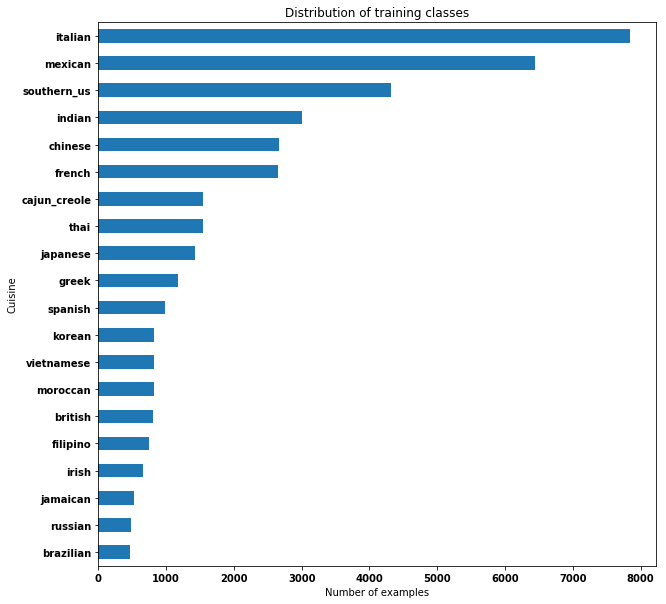

In [6]:
# Plot distribution of training classes
plt.figure(figsize=(10,10))
f = y_values = y_train_all.value_counts().plot(kind='barh')
f.invert_yaxis()
plt.title("Distribution of training classes")
plt.ylabel("Cuisine")
plt.xlabel("Number of examples");

#### Number of Ingredients per Recipe

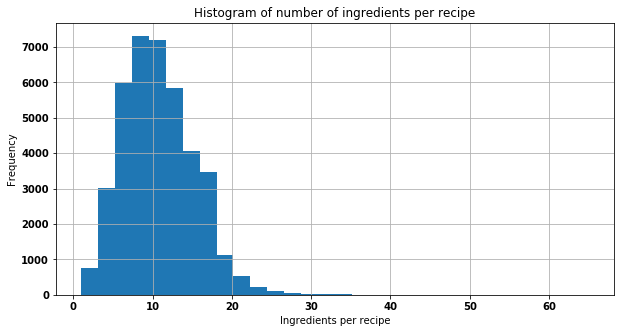

In [7]:
plt.figure(figsize=(10,5))
f = X_train_all.apply(len).hist(bins=30)
plt.title("Histogram of number of ingredients per recipe")
plt.ylabel("Frequency")
plt.xlabel("Ingredients per recipe");

#### Top Ingredients - Across All Cuisines

The top ingredients seem to be very common ingredients like salt, sugar, oil, etc. which may not be cusine-specific. These features could potentially be ruled out (or let the model feature-select). Here we can also see that there are similar ingredients that should be deduplicated (e.g. kosher salt and salt, olive oil and oil). 

In [8]:
# For each row, go through each ingredient and create a cuisine-ingredient pair
ing_cuisine_pair = []
for i in range(X_train_all.shape[0]):
    for ingredient in X_train_all[i]:
        ing_cuisine_pair.append([y_train_all[i], ingredient])

ing_cuisine = pd.DataFrame(ing_cuisine_pair, columns=['cuisine', 'ingredient'])

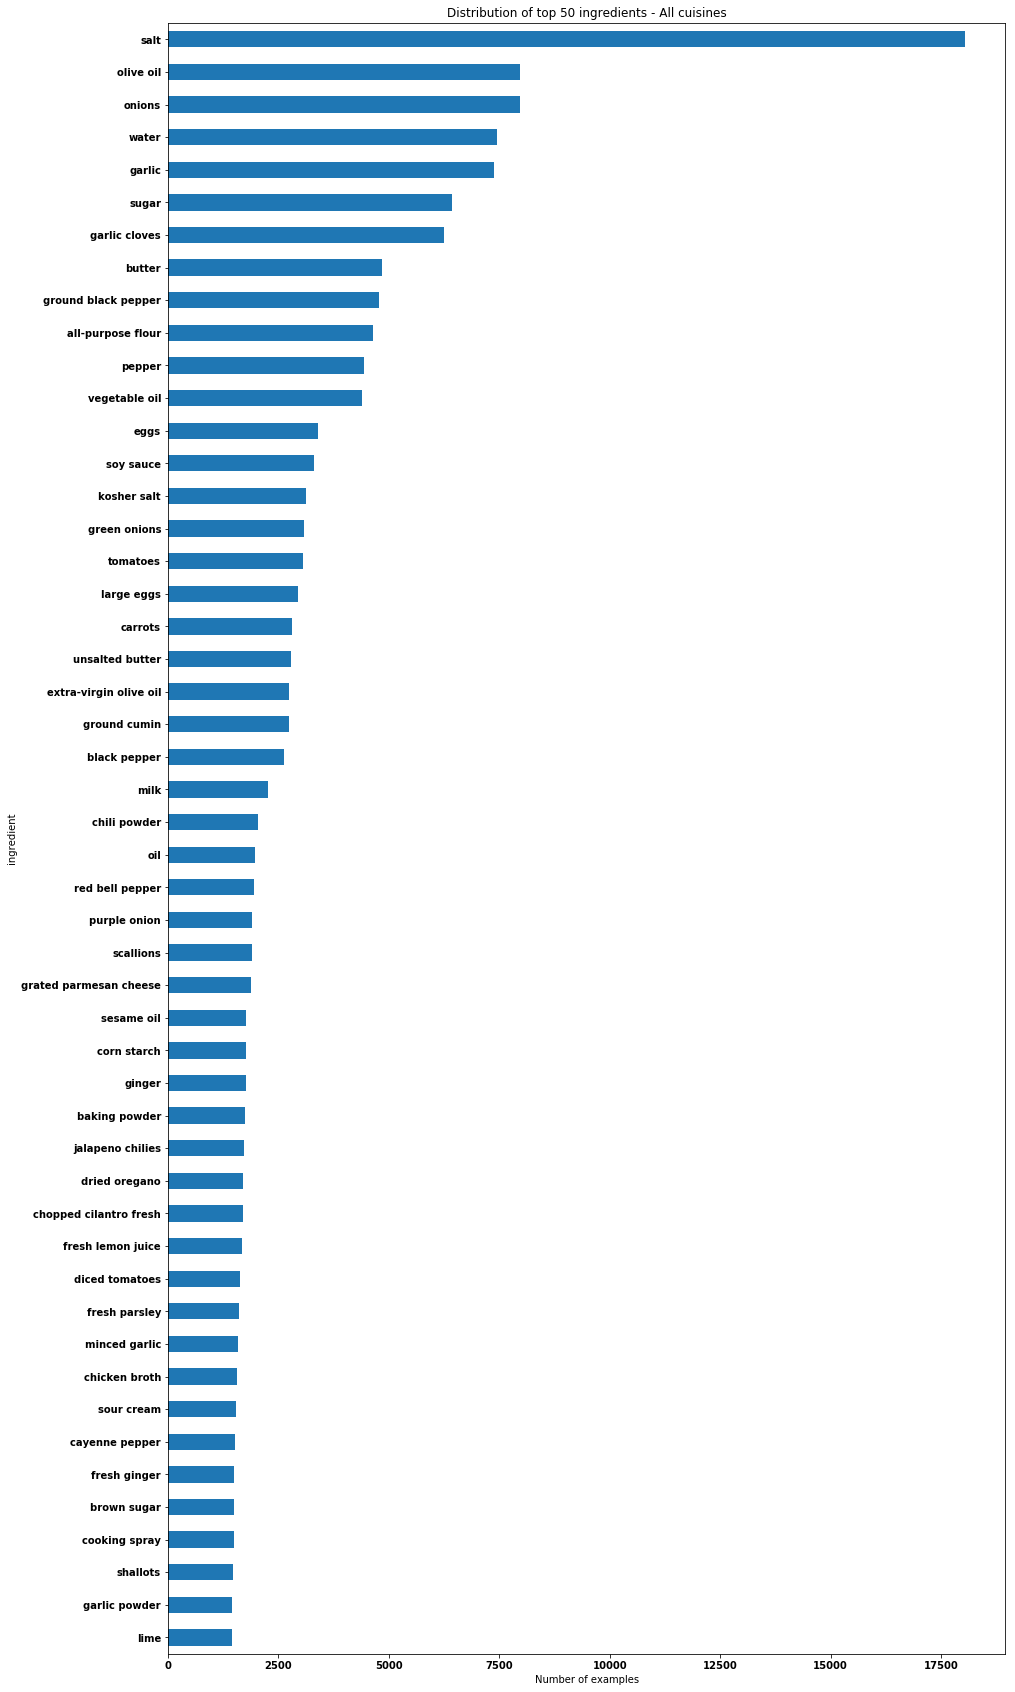

In [9]:
plt.figure(figsize=(15,30))
plt.title("Distribution of top 50 ingredients - All cuisines")
plt.ylabel("ingredient")
plt.xlabel("Number of examples")
f = ing_cuisine['ingredient'].value_counts()[:50].plot(kind='barh')
f.invert_yaxis()

#### Top Ingredients - By Cuisine

Similarly, here by cuisine the top ingredients are common ingredients like salt, but we start to see some cuisine-specific incredients like jalapeno chilies for Mexican and soy sauce for Chinese.

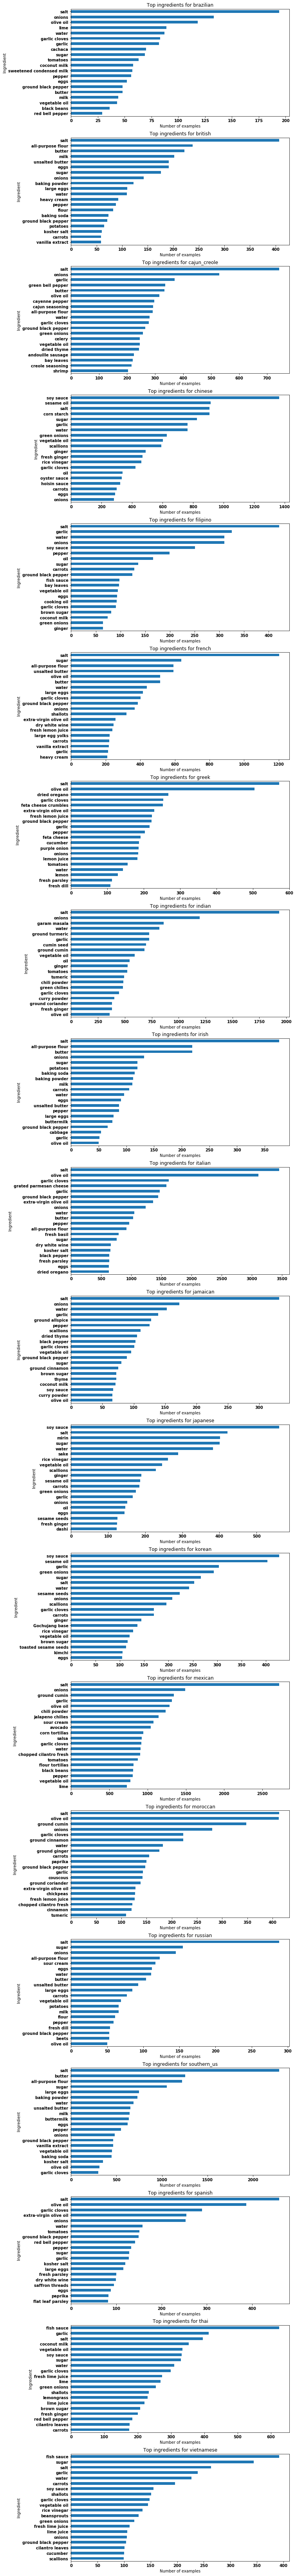

In [10]:
# Top ingredients by cuisine
plt.figure(figsize=(10,120))

grouped = ing_cuisine.groupby('cuisine')

cuisines = list(grouped.groups.keys())
for i in range(len(cuisines)):
    plt.subplot(20, 1, i+1)
    
    f = ing_cuisine[ing_cuisine['cuisine'] == cuisines[i]]['ingredient'].value_counts()[:20].plot(kind='barh')
    f.invert_yaxis()
    plt.title("Top ingredients for %s" % cuisines[i])
    plt.ylabel("Ingredient")
    plt.xlabel("Number of examples")
    i+=1

plt.show()

#### Unique ingredients

In [11]:
d = pd.DataFrame(ing_cuisine['ingredient'].value_counts())
print(d)

                                      ingredient
salt                                       18049
olive oil                                   7972
onions                                      7972
water                                       7457
garlic                                      7380
sugar                                       6434
garlic cloves                               6237
butter                                      4848
ground black pepper                         4785
all-purpose flour                           4632
pepper                                      4438
vegetable oil                               4385
eggs                                        3388
soy sauce                                   3296
kosher salt                                 3113
green onions                                3078
tomatoes                                    3058
large eggs                                  2948
carrots                                     2814
unsalted butter     

## Baseline Data Preparation

In [12]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train_all, y_train_all, random_state=2)

In [13]:
print("The shape of X_train is", X_train.shape)
print("The shape of X_dev is ", X_dev.shape)
print("The shape of y_train is", y_train.shape)
print("The shape of y_dev is", y_dev.shape)

The shape of X_train is (29830,)
The shape of X_dev is  (9944,)
The shape of y_train is (29830,)
The shape of y_dev is (9944,)


In [14]:
def list_to_string(l):
    return ','.join(l).replace(' ', '_').replace('|', ' ')

X_train_str = X_train.apply(list_to_string)
X_dev_str = X_dev.apply(list_to_string)

## Baseline Model

#### Training

For the baseline model, we are starting with a very simple logistic regression model with no hyperparameter tuning. We will also be using a very basic count vectorizer. The goal of this is really to establish a baseline and understand what the metrics are for this very basic model.

In [15]:
base_pipeline = Pipeline(steps=[
    ('countvectorizer', CountVectorizer()),
    ('lr', LogisticRegression()),
])
base_pipeline.fit(X_train_str, y_train)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

#### Evaluation - Accuracy

Note that accuracy is NOT a good measure here especially given that there is high class imbalance. This is only calculated to establish a baseline.

In [16]:
print("Accuracy of the base model on the training data is", base_pipeline.score(X_train_str, y_train))
print("Accuracy of the base model on the dev data is", base_pipeline.score(X_dev_str, y_dev))

Accuracy of the base model on the training data is 0.876567214214
Accuracy of the base model on the dev data is 0.776850362027


#### Evaluation - Precision & Recall

Precision and recall are better measures to use here with high class imbalance.

In [17]:
y_pred = base_pipeline.predict(X_dev_str)
print("Precision of the base model is", precision_score(y_dev, y_pred, average='macro'))
print("Recall of the base model is", recall_score(y_dev, y_pred, average='macro'))
print("Recall of the base model is", f1_score(y_dev, y_pred, average='macro'))

Precision of the base model is 0.753728440323
Recall of the base model is 0.659289626281
Recall of the base model is 0.695687733957


#### Confusion matrix

In [40]:
conf_mat = confusion_matrix(y_dev, y_pred)
conf_mat_abs = pd.DataFrame(conf_mat, index=base_pipeline.classes_, columns=base_pipeline.classes_)
display(conf_mat_abs)
conf_mat_perc = pd.DataFrame((conf_mat.T/conf_mat.sum(axis=1)).T, index=base_pipeline.classes_, columns=base_pipeline.classes_)
display(conf_mat_perc)

brazilian  british  cajun_creole  chinese  filipino  french  \
brazilian            64        0             2        0         2       4   
british               2       65             1        1         0      37   
cajun_creole          1        3           267        1         0      10   
chinese               0        0             2      556        11       4   
filipino              4        0             0       18       113       4   
french                0        4             5        1         2     407   
greek                 0        0             0        0         0       6   
indian                1        0             1        3         2       5   
irish                 0       15             0        1         0      21   
italian               0        6             5        1         1      84   
jamaican              2        0             2        2         4       2   
japanese              1        0             1       30         2       9   
korean                0        0             0       25         1       1   
mexican               5        0             4        5         4      14   
moroccan              0        1             3        0         0       4   
russian               0        5             2        0         3      20   
southern_us           2       12            30        7         3      44   
spanish               1        1             0        1         1      27   
thai                  3        0             1       22         4       1   
vietnamese            1        0             0       17         4       2   

              greek  indian  irish  italian  jamaican  japanese  korean  \
brazilian         0       4      0        6         5         0       0   
british           1       7      9       16         0         1       1   
cajun_creole      1       1      0       25         0         0       1   
chinese           0       8      0        8         1        19      12   
filipino          0       1      2        8         1         0       1   
french            9       3      8      119         0         1       0   
greek           172       4      0       58         0         1       0   
indian            4     666      0       15         0        10       0   
irish             1       2     70       21         0         0       0   
italian          18       6      2     1764         0         0       0   
jamaican          0      11      1        3        72         2       0   
japanese          1      28      0        8         0       237       6   
korean            0       1      0        3         0         8     170   
mexican           3       4      0       45         1         1       0   
moroccan          6      15      1        8         1         0       0   
russian           2       3      3       15         0         1       0   
southern_us       4       3      6       58         6         6       0   
spanish           4       1      0       61         0         0       0   
thai              0       8      0        4         1         3       3   
vietnamese        1       3      0        5         0         2       3   

              mexican  moroccan  russian  southern_us  spanish  thai  \
brazilian          17         0        1            9        3     4   
british             3         0        4           56        2     0   
cajun_creole        8         0        1           56        1     0   
chinese             7         1        2            9        0    18   
filipino            8         0        1           16        1     6   
french              6         4        4           52       11     0   
greek               1         4        1            5        6     0   
indian             19        15        0            4        0    13   
irish               2         0        2           38        1     1   
italian            19         5        0           45        6     1   
jamaican            5       

brazilian   british  cajun_creole   chinese  filipino    french  \
brazilian      0.528926  0.000000      0.016529  0.000000  0.016529  0.033058   
british        0.009709  0.315534      0.004854  0.004854  0.000000  0.179612   
cajun_creole   0.002660  0.007979      0.710106  0.002660  0.000000  0.026596   
chinese        0.000000  0.000000      0.002985  0.829851  0.016418  0.005970   
filipino       0.021053  0.000000      0.000000  0.094737  0.594737  0.021053   
french         0.000000  0.006289      0.007862  0.001572  0.003145  0.639937   
greek          0.000000  0.000000      0.000000  0.000000  0.000000  0.023256   
indian         0.001319  0.000000      0.001319  0.003958  0.002639  0.006596   
irish          0.000000  0.085714      0.000000  0.005714  0.000000  0.120000   
italian        0.000000  0.003057      0.002547  0.000509  0.000509  0.042792   
jamaican       0.016260  0.000000      0.016260  0.016260  0.032520  0.016260   
japanese       0.002924  0.000000      0.002924  0.087719  0.005848  0.026316   
korean         0.000000  0.000000      0.000000  0.113122  0.004525  0.004525   
mexican        0.002998  0.000000      0.002398  0.002998  0.002398  0.008393   
moroccan       0.000000  0.004651      0.013953  0.000000  0.000000  0.018605   
russian        0.000000  0.037594      0.015038  0.000000  0.022556  0.150376   
southern_us    0.001894  0.011364      0.028409  0.006629  0.002841  0.041667   
spanish        0.004049  0.004049      0.000000  0.004049  0.004049  0.109312   
thai           0.007673  0.000000      0.002558  0.056266  0.010230  0.002558   
vietnamese     0.005128  0.000000      0.000000  0.087179  0.020513  0.010256   

                 greek    indian     irish   italian  jamaican  japanese  \
brazilian     0.000000  0.033058  0.000000  0.049587  0.041322  0.000000   
british       0.004854  0.033981  0.043689  0.077670  0.000000  0.004854   
cajun_creole  0.002660  0.002660  0.000000  0.066489  0.000000  0.000000   
chinese       0.000000  0.011940  0.000000  0.011940  0.001493  0.028358   
filipino      0.000000  0.005263  0.010526  0.042105  0.005263  0.000000   
french        0.014151  0.004717  0.012579  0.187107  0.000000  0.001572   
greek         0.666667  0.015504  0.000000  0.224806  0.000000  0.003876   
indian        0.005277  0.878628  0.000000  0.019789  0.000000  0.013193   
irish         0.005714  0.011429  0.400000  0.120000  0.000000  0.000000   
italian       0.009170  0.003057  0.001019  0.898625  0.000000  0.000000   
jamaican      0.000000  0.089431  0.008130  0.024390  0.585366  0.016260   
japanese      0.002924  0.081871  0.000000  0.023392  0.000000  0.692982   
korean        0.000000  0.004525  0.000000  0.013575  0.000000  0.036199   
mexican       0.001799  0.002398  0.000000  0.026978  0.000600  0.000600   
moroccan      0.027907  0.069767  0.004651  0.037209  0.004651  0.000000   
russian       0.015038  0.022556  0.022556  0.112782  0.000000  0.007519   
southern_us   0.003788  0.002841  0.005682  0.054924  0.005682  0.005682   
spanish       0.016194  0.004049  0.000000  0.246964  0.000000  0.000000   
thai          0.000000  0.020460  0.000000  0.010230  0.002558  0.007673   
vietnamese    0.005128  0.015385  0.000000  0.025641  0.000000  0.010256   

                korean   mexican  moroccan   russian  southern_us   spanish  \
brazilian     0.000000  0.140496  0.000000  0.008264     0.074380  0.024793   
british       0.004854  0.014563  0.000000  0.019417     0.271845  0.009709   
cajun_creole  0.002660  0.021277  0.000000  0.002660     0.148936  0.002660   
chinese       0.017910  0.010448  0.001493  0.002985     0.013433  0.000000   
filipino      0.005263  0.042105  0.000000  0.005263     0.084211  0.005263   
french        0.000000  0.009434  0.006289  0.006289     0.081761  0.017296   
greek         0.000000  0.003876  0.015504  0.003876     0.019380  0.023256   
indian        0.000000  0.025066  0.019789  0.000000     0.005277  0.000000   
iris

# ADD EVERYTHING BELOW

One aspect of the model that is useful to explore is the confidence of each classification. We can use this information to detect which recipe's our model was very confident about, and which ones it was deciding between several options.

In [111]:
# Calculate confidence in classification and actual class probability
df_probs = pd.DataFrame(base_pipeline.predict_proba(X_dev_str), columns=base_pipeline.classes_)
df_probs['ingredients'] = X_dev.reset_index(drop=True)
df_probs['class'] = y_dev.reset_index(drop=True)
df_probs['prediction'] = base_pipeline.predict(X_dev_str)
df_probs['confidence'] = np.max(base_pipeline.predict_proba(X_dev_str), axis=1)
df_probs['class_prob'] = df_probs.apply(lambda row: row[str(row['class'])], axis=1)
df_probs['R'] = df_probs['confidence']/df_probs['class_prob']
df_probs['correct'] = df_probs['class'] == df_probs['prediction']
df_probs = df_probs[['ingredients', 'correct', 'class', 'class_prob', 'prediction', 'confidence', 'R']]

Looking at the incorrectly classified examples where the *R* metric is smallest, we can see examples where the model almost predicted the right class and was simply choosing between two good options. We can see this in the first example where it barely picked Thai over Indian, likely due to the coconut milk. Also, the last dish in the list below is clearly a recipe for bread, which is difficult to discern as the ingredients are fairly standard across different cusines.

In [155]:
pd.set_option('display.max_colwidth', -1)
keep_cols = ['class','prediction','class_prob','confidence','ingredients']
df_probs[~df_probs['correct']].sort_values('R')[keep_cols].head(7)

class prediction  class_prob  confidence  \
4154  indian       thai       0.376567    0.376755     
4621  french       italian    0.426179    0.426583     
2576  chinese      thai       0.481796    0.482583     
7017  indian       filipino   0.296405    0.296901     
344   italian      french     0.452432    0.453596     
8472  southern_us  french     0.293761    0.294663     
5621  mexican      indian     0.181904    0.182673     

                                                                                                                                                                                                                         ingredients  
4154  [boneless chicken breast, masala, coconut milk, cilantro, tomato purÃ©e, roasted tomatoes]                                                                                                                                      
4621  [black pepper, cayenne pepper, capers, fresh thyme leaves, fresh lemon juice, pitted black olives, garlic, olive oil, anchovy fillets]                                                                                          
2576  [curry powder, crushed red pepper flakes, oyster sauce, straw mushrooms, green onions, peanut oil, boneless skinless chicken breast halves, soy sauce, water chestnuts, peanut butter, noodles, fresh ginger, garlic, carrots]  
7017  [garlic, onions, pepper, oil, cayenne, carrots, tumeric, salt, curry leaf]                                                                                                                                                      
344   [chicken stock, ground black pepper, extra-virgin olive oil, white wine, boneless chicken breast, fresh lemon juice, capers, unsalted butter, all-purpose flour, minced garlic, sea salt, fresh parsley]                        
8472  [wheat bread, apples, water, brown sugar, salted butter]                                                                                                                                                                        
5621  [flour, salt, warm water, oil, baking powder]

Similarly, we can view the samples that it got very wrong and see which features may have convinced it to classify incorrectly with such confidence. In the first example below, *jalapeno chilies, adobe* and *Mexican oregano* all make this seem pretty convincingly a Mexican dish. In fact, I'm not totally convinced that this isn't a Mexican dish that was incorrectly labeled.

In [153]:
pd.set_option('display.max_colwidth', -1)
keep_cols = ['class','prediction','class_prob','confidence','ingredients']
df_probs[~df_probs['correct']].sort_values('R', ascending=False)[keep_cols].head(5)

class prediction  class_prob  confidence  \
3095  chinese   mexican    0.000025    0.925533     
6150  irish     italian    0.000044    0.613921     
7718  spanish   russian    0.000085    0.641921     
7733  filipino  mexican    0.000138    0.688423     
9902  irish     italian    0.000193    0.813759     

                                                                                                                                                                                                                                                                                                                    ingredients  
3095  [suckling pig, bay leaves, worcestershire sauce, salt, lard, white onion, jalapeno chilies, raisins, red bliss potato, carrots, green apples, tomatoes, ground black pepper, Mexican oregano, fresh orange juice, pimento stuffed olives, fresh lime juice, adobo, fresh thyme, cinnamon, garlic, juice, fresh pineapple]  
6150  [olive oil, long-grain rice, water, zucchini, sliced mushrooms, fresh basil, beef, garlic cloves, yellow squash, chopped onion, plum tomatoes]                                                                                                                                                                             
7718  [warm water, honey, port, walnuts, ground cinnamon, molasses, unsalted butter, all-purpose flour, sugar, active dry yeast, large eggs, candied fruit, ground ginger, ground cloves, baking soda, salt, dried cranberries]                                                                                                  
7733  [lime juice, green onions, boneless skinless chicken breast halves, olive oil, fresh oregano, fresh cilantro, salt, ground cumin, pepper, fresh thyme, garlic cloves]                                                                                                                                                      
9902  [olive oil, cooking spray, 1% low-fat milk, garlic cloves, ground black pepper, chopped fresh thyme, salt, Italian bread, cremini mushrooms, large eggs, dry mustard, chopped onion, fresh parmesan cheese, ground red pepper, chopped celery, turkey breast]

In [132]:
df_probs[~df_probs['correct']].sort_values('R', ascending=False).head(10)

ingredients  correct     class  \
3095  [suckling pig, bay leaves, worcestershire sauc...    False   chinese   
6150  [olive oil, long-grain rice, water, zucchini, ...    False     irish   
7718  [warm water, honey, port, walnuts, ground cinn...    False   spanish   
7733  [lime juice, green onions, boneless skinless c...    False  filipino   
9902  [olive oil, cooking spray, 1% low-fat milk, ga...    False     irish   
4033  [ground ginger, shiitake, water chestnuts, veg...    False  filipino   
1195  [onion powder, ground cumin, ground black pepp...    False  filipino   
4346  [water, cooking spray, shredded sharp cheddar ...    False   italian   
9643  [vegetable oil, minced beef, ground cumin, bee...    False  filipino   
8389  [white vinegar, brown sugar, granulated sugar,...    False   spanish   

      class_prob   prediction  confidence             R  
3095    0.000025      mexican    0.925533  37588.796535  
6150    0.000044      italian    0.613921  13829.900545  
7718    0.000085      russian    0.641921   7519.018999  
7733    0.000138      mexican    0.688423   4973.583111  
9902    0.000193      italian    0.813759   4206.248480  
4033    0.000228      chinese    0.927983   4061.727883  
1195    0.000214      mexican    0.819691   3828.976713  
4346    0.000261  southern_us    0.906218   3470.620374  
9643    0.000262      mexican    0.794758   3036.260127  
8389    0.000368  southern_us    0.825693   2240.923240

The calibration curve below shows that logistic regression is slightly overconfident when making it's predictions. It's typically overconfident by 5-10%.

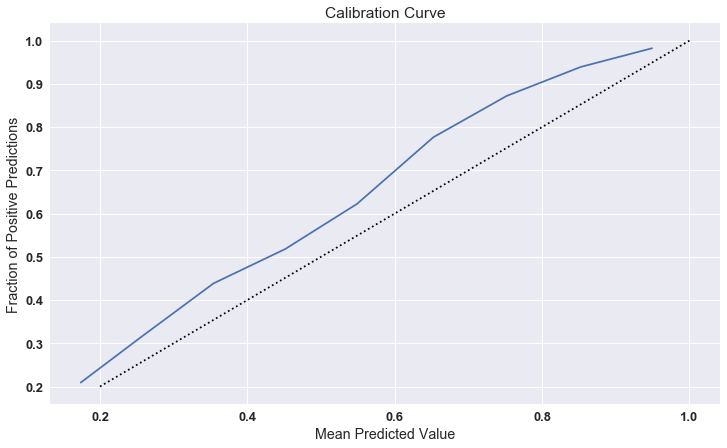

In [149]:
from sklearn.calibration import calibration_curve
frac_of_pos, mean_pred_val = calibration_curve(df_probs['correct'], df_probs['confidence'], n_bins=10)
plt.figure(figsize=(12,7))
plt.title('Calibration Curve')
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positive Predictions')
plt.plot([0.2, 1], [0.2, 1], "k:")
plt.plot(mean_pred_val, frac_of_pos);

# Other Methods attempted

We ultimately found that SVM worked the best given our preprocessing choices. However, before examining that we will discuss some of the other metheods attempted.

### __N-Gram Vectorization:__

We did attempt several vectorizations to test if they would work. Though we were skeptical of it, we did try to use n-gram vectorization and removed the preprocessing step where we combined the entire ingredient into one string. This was ultimately ineffective as even when using a minimum document frequency parameter to filter out noise, it created a large noisy vectorization of the problem. For instance, if you had the following ingredients *sugar, salted butter, low fat milk* you would get the following features (*sugar salted, salted butter, butter low, low fat, fat milk*). As suspected this vectorization scheme was unsuccessful and we ultimately chose to stay with our method of keeping all ingredients as self contained strings.


### __Naive Bayes:__

We tried using a Naive Bayes approach to try and identify the recipes, because Naive bayes has a good track record with text classification. The fact that Naive Bayes assumes independence allows for it to steer clear of the trap of overfitting that is common with high dimensional problems. 

However, after attempting to run it with several different vectorizations it proved to ultimately perform worse than our baseline model, with an accuracy of 0.75 and lower precision and recall scores. Logistic regression may have proved to be a better option since there are so few ingredients for each recipe and the interaction between variables can be very important. For instance, rice is a fairly generic ingredient and not all that informative on its own. However, rice with corriander may be more highly associated with indian food in comparison to rice with coconut milk. The Naive Bayes method did prove to have less overfitting, but ultimately sacrificed accuracy.

### __Clustering Ensemble:__

Another method we tried was to group the recipes into distinct clusters and then fit an SVM on each one. The idea behind this is that you may have several clusters that are similar to one another that can be linearly separated by a classifier trained specifically on that cluster as opposed to coming up with on classifier which generalizes well to each cluster. 

This method also proved worse than our baseline. While it did perform very well on several of the clusters it managed to group many of the poor performing groups together. The several clusters had an 85% accuracy while the worst performing cluster was 60%. While this method did not improve performance it did show that there was a correlation between the performance of the various models and the number of ingredients within each recipe. The clustering method seemed to group the recipes into those with many ingredients and those with fewer ingredients. Those with fewer ingredients always performed worse. 

This shows how our initial inclination to reduce the feature space using the broadmatch method may have been misguided and why it led to poorer performance.

### __XGBoost:__

We attempted to use the XGBoost package, because of its track record solving a variety of problems. It also does a better job of trying to solve the problem we were trying to address with clustering. After correctly classifying several examples, it will focus on the samples that it gets wrong and try to get them right. It also employs a degree of regularization to avoid overfitting and keeping the model generalizable. 

Unfortunatley, this method did not perform well either. After tuning hyperparameters, the best performance we were able to get was 75%. 

## SVM

#### Training

For the final model we introduce several new components. A slightly updated preprocessing step, a TF-IDF vectorization, and a linear support vector machine (SVM). 

The new preprocessing step follows the same logic as in the baseline, except that it also filters out any numbers and non-letter characters. This way we were able to ensure that some features such as *low fat milk* and *low-fat milk* were not tokenized as separate ingredients.

The TF-IDF vectorizer is a way of downweighting common samples and upweighting rare samples. There are two major components to this vectorization, term-frequency which counts how often the term shows up in the document, and inverse-document-frequency which calculates how many documents out of the corpus contain that particular term. The term-frequency does not factor in for this particular problem as we are tokenizing each ingredient individually, and no ingredient will appear in a recipe more than once. However, the inverse document frequency is useful for downweighting the ingredients that appear in many recipes, such as *salt*, *water*, etc.

The final algorithm that we chose to go with was a Linear SVM. SVM's are good at finding linear and non-linear boundaries for classification. Another reason we decided to try it is that it generalizes better than logistic regression does. We chose a Linear SVM, due to the high dimensionality of the problem we are training. However, we did test our problem with other kernels to verify that a linear SVM was the correct choice.

In [92]:
# Preprocess data by removing special characters and grouping each ingredient separately
def list_to_string(l):
    l = [re.sub('[^A-Za-z]',' ',x).strip() for x in l]
    return ','.join(l).replace(' ', '_').replace('|', ' ')

X_train_str = X_train.apply(list_to_string)
X_dev_str = X_dev.apply(list_to_string)

In [134]:
# Import the necessary models for SVM and TFIDF

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

svc_pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words='english',analyzer="word", token_pattern=r'\w+', max_features=5500, max_df=0.45)),
    ('svm', LinearSVC(penalty='l2', C=0.38, class_weight=None)),
])

svc_pipe.fit(X_train_str, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.45, max_features=5500, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

#### Evaluation - Accuracy

Note that accuracy is NOT a good measure here especially given that there is high class imbalance. However, it is still the classical method used to assess the performance of a model and we will use it to get a high level view of overall performance.

In [136]:
print("Accuracy of the base model on the training data is", grid_search.score(X_train_str, y_train))
print("Accuracy of the base model on the dev data is", grid_search.score(X_dev_str, y_dev))

Accuracy of the base model on the training data is 0.881595709018
Accuracy of the base model on the dev data is 0.78268302494


#### Evaluation - Precision & Recall

In [137]:
y_pred = grid_search.predict(X_dev_str)
print("Precision of the base model is", precision_score(y_dev, y_pred, average='macro'))
print("Recall of the base model is", recall_score(y_dev, y_pred, average='macro'))
print("F1 of the base model is", f1_score(y_dev, y_pred, average='macro'))

Precision of the base model is 0.75358284161
Recall of the base model is 0.666565123836
F1 of the base model is 0.699876054315


From our high level accuracy methods it seems that the Linear SVC slightly outperformed the logistic regression model. Our precision, recall, and f1-score all showed slight improvement which is a better indicator to use when assessing multiple classes. This shows that overall the SVM did improve the overall results. This may be because the SVM will not only find a decision boundary, but it will typically find the best decision boundary and therefore generalizes better to new data.

#### Confusion matrix

As seen in the confusion matrix below, we still have much confusion between Italian and French. This problem persists as there are many overlapping ingredients used often in the cuisine of both nations. Also, *southern_us* is predicted more often than it should be with this model. An attempt to account for this with balanced classes was used, but proved ultimately unsuccessful as it was with logistic regression.

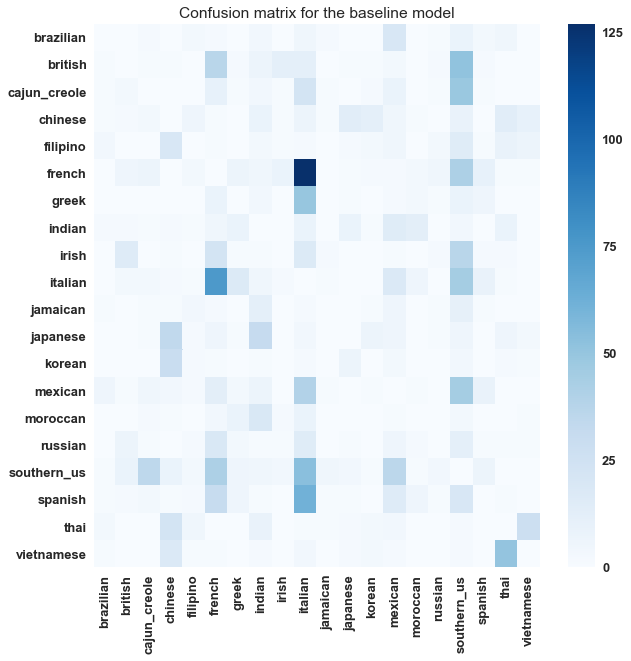

In [142]:
cm = confusion_matrix(y_dev, y_pred)
np.fill_diagonal(cm, 0)
cm_df = pd.DataFrame(cm, index=base_pipeline.classes_, columns=base_pipeline.classes_)

plt.figure(figsize=(10,10))
sn.set(font_scale=1.3)
ax = sn.heatmap(cm_df, cmap="Blues")
plt.title("Confusion matrix for the baseline model");

# Conclusion

There were several methods that we considered trying, but did not have the time to implement. One method was to use python's TextBlob package to potentially filter out certain parts of words. Another method would be to scroll over each word in the ingredient list and detect the individual language. Language could provide a good indication when ingredients are fairly similar, or if there are some ingredients that are rare in the overall corpus such as *poisson* the french word for fish.

Another method that we did not get to implement was including the number of ingredients as a feature. The clustering ensemble method was performed late in the analysis, but did show that there was some potential for more ingredients contributing to better fit. Perhaps the some cuisines would use more ingredients and thus be easier to detect, such as indian recipes which have a considerable number of spices in them. We were not able to explore this as we ran out of time.